# Requirements



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

In [3]:
import os
project_path = "/content/drive/MyDrive/RL_Project/codes"
os.chdir(project_path)

In [ ]:
pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import pickle
import gym
from DroneDelivery_Env import DroneDeliveryMultiAgentEnv
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Hyperparameters

In [ ]:
STATE_SIZE = DroneDeliveryMultiAgentEnv().get_obs_size()
STATE_DIM = DroneDeliveryMultiAgentEnv().get_state_size()
ACTION_SIZE = DroneDeliveryMultiAgentEnv().action_space.n
NUM_AGENTS = DroneDeliveryMultiAgentEnv().num_drones
EPISODES = 2000
MAX_STEPS = 100
BATCH_SIZE = 64
BUFFER_SIZE = 10000
GAMMA = 0.99
LR = 0.001
TARGET_UPDATE = 50


# Networks

In [ ]:
class AgentQNetwork(nn.Module):
    def __init__(self, obs_size, action_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )
    def forward(self, obs):
        return self.net(obs)
class MixerNetwork(nn.Module):
    def __init__(self, num_agents, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, num_agents)
    def forward(self, agent_qs, state):
        w = torch.abs(self.fc1(state))
        y = self.fc2(torch.relu(w))
        return torch.sum(agent_qs * y, dim=1, keepdim=True)
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    def push(self, obs, state, actions, rewards, next_obs, next_state, dones):
        self.buffer.append((obs, state, actions, rewards, next_obs, next_state, dones))
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        obs, state, actions, rewards, next_obs, next_state, dones = map(np.array, zip(*samples))
        return obs, state, actions, rewards, next_obs, next_state, dones
    def __len__(self):
        return len(self.buffer)


#Initialize

In [ ]:
env = DroneDeliveryMultiAgentEnv()
agents_q_net = [AgentQNetwork(STATE_SIZE, ACTION_SIZE).to(device) for _ in range(NUM_AGENTS)]
agents_target_q_net = [AgentQNetwork(STATE_SIZE, ACTION_SIZE).to(device) for _ in range(NUM_AGENTS)]
mixer = MixerNetwork(NUM_AGENTS, STATE_DIM).to(device)
target_mixer = MixerNetwork(NUM_AGENTS, STATE_DIM).to(device)
optimizers = [optim.Adam(q.parameters(), lr=LR) for q in agents_q_net]
mixer_optimizer = optim.Adam(mixer.parameters(), lr=LR)
buffer = ReplayBuffer(BUFFER_SIZE)
for tq, q in zip(agents_target_q_net, agents_q_net):
    tq.load_state_dict(q.state_dict())
target_mixer.load_state_dict(mixer.state_dict())
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
save_dir = "/content/temp"
os.makedirs(save_dir, exist_ok=True)
rewards_per_episode = []
epsilons_per_episode = []


##Training

In [4]:
for ep in range(EPISODES):
    obs_dict, _ = env.reset()
    obs = np.array([obs_dict[aid] for aid in env.agent_ids])
    state = env.get_centralized_state()
    total_reward = 0
    for step in range(MAX_STEPS):
        actions = []
        for i in range(NUM_AGENTS):
            if random.random() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = agents_q_net[i](torch.tensor(obs[i], dtype=torch.float32, device=device))
                    a = q_values.argmax().item()
            actions.append(a)
        action_dict = {env.agent_ids[i]: actions[i] for i in range(NUM_AGENTS)}
        next_obs_dict, rewards_dict, dones_dict, truncs_dict, info = env.step(action_dict)
        next_obs = np.array([next_obs_dict[aid] for aid in env.agent_ids])
        next_state = info["state"]
        buffer.push(obs, state, actions, list(rewards_dict.values()), next_obs, next_state, list(dones_dict.values()))
        obs, state = next_obs, next_state
        total_reward += sum(rewards_dict.values())
        if all(dones_dict.values()):
            break
        if len(buffer) >= BATCH_SIZE:
            batch_obs, batch_state, batch_actions, batch_rewards, batch_next_obs, batch_next_state, batch_dones = buffer.sample(BATCH_SIZE)
            batch_obs = torch.tensor(batch_obs, dtype=torch.float32, device=device)
            batch_state = torch.tensor(batch_state, dtype=torch.float32, device=device)
            batch_actions = torch.tensor(batch_actions, dtype=torch.long, device=device)
            batch_rewards = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
            batch_next_obs = torch.tensor(batch_next_obs, dtype=torch.float32, device=device)
            batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32, device=device)
            batch_dones = torch.tensor(batch_dones, dtype=torch.float32, device=device)
            q_values = []
            next_q_values = []
            for i in range(NUM_AGENTS):
                q = agents_q_net[i](batch_obs[:, i])
                q_val = q.gather(1, batch_actions[:, i].unsqueeze(1))
                q_values.append(q_val)
                with torch.no_grad():
                    next_q = agents_target_q_net[i](batch_next_obs[:, i])
                    next_q_val = next_q.max(1, keepdim=True)[0]
                    next_q_values.append(next_q_val)
            q_values = torch.cat(q_values, dim=1)
            next_q_values = torch.cat(next_q_values, dim=1)
            mixed_q = mixer(q_values, batch_state)
            target_mixed_q = mixer(next_q_values, batch_next_state)
            target = batch_rewards.sum(1, keepdim=True) + GAMMA * target_mixed_q * (1 - batch_dones.sum(1, keepdim=True))
            loss = nn.MSELoss()(mixed_q, target)
            mixer_optimizer.zero_grad()
            for opt in optimizers:
                opt.zero_grad()
            loss.backward()
            mixer_optimizer.step()
            for opt in optimizers:
                opt.step()
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)
    epsilons_per_episode.append(epsilon)
    print(f"Episode {ep+1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.4f}")
    if (ep + 1) % 100 == 0:
        np.save(os.path.join(save_dir, f"rewards_ep{ep+1}.npy"), np.array(rewards_per_episode))
        np.save(os.path.join(save_dir, f"epsilons_ep{ep+1}.npy"), np.array(epsilons_per_episode))
        print(f"Saved intermediate rewards and epsilons at episode {ep+1}")
torch.save({
    'agents_q_net': [q.state_dict() for q in agents_q_net],
    'mixer': mixer.state_dict(),
    'epsilon': epsilon
}, os.path.join(save_dir, "model_final.pt"))
with open(os.path.join(save_dir, "model_final.pkl"), "wb") as f:
    pickle.dump({'agents_q_net': agents_q_net, 'mixer': mixer}, f)
np.save(os.path.join(save_dir, "rewards.npy"), np.array(rewards_per_episode))
np.save(os.path.join(save_dir, "epsilons.npy"), np.array(epsilons_per_episode))
print("Training complete! Final models and rewards saved.")

Episode 1: Total Reward = -2456.40, Epsilon = 0.9950
Episode 2: Total Reward = -2433.80, Epsilon = 0.9900
Episode 3: Total Reward = -2084.80, Epsilon = 0.9851
Episode 4: Total Reward = -2367.00, Epsilon = 0.9801
Episode 5: Total Reward = -2849.60, Epsilon = 0.9752
Episode 6: Total Reward = -2724.40, Epsilon = 0.9704
Episode 7: Total Reward = -1873.00, Epsilon = 0.9655
Episode 8: Total Reward = -2779.20, Epsilon = 0.9607
Episode 9: Total Reward = -2307.40, Epsilon = 0.9559
Episode 10: Total Reward = -2303.20, Epsilon = 0.9511
Episode 11: Total Reward = -2009.80, Epsilon = 0.9464
Episode 12: Total Reward = -1842.80, Epsilon = 0.9416
Episode 13: Total Reward = -3267.20, Epsilon = 0.9369
Episode 14: Total Reward = -3283.80, Epsilon = 0.9322
Episode 15: Total Reward = -2215.40, Epsilon = 0.9276
Episode 16: Total Reward = -2385.20, Epsilon = 0.9229
Episode 17: Total Reward = -1829.60, Epsilon = 0.9183
Episode 18: Total Reward = -1771.60, Epsilon = 0.9137
Episode 19: Total Reward = -2945.00, 

#Evaluation

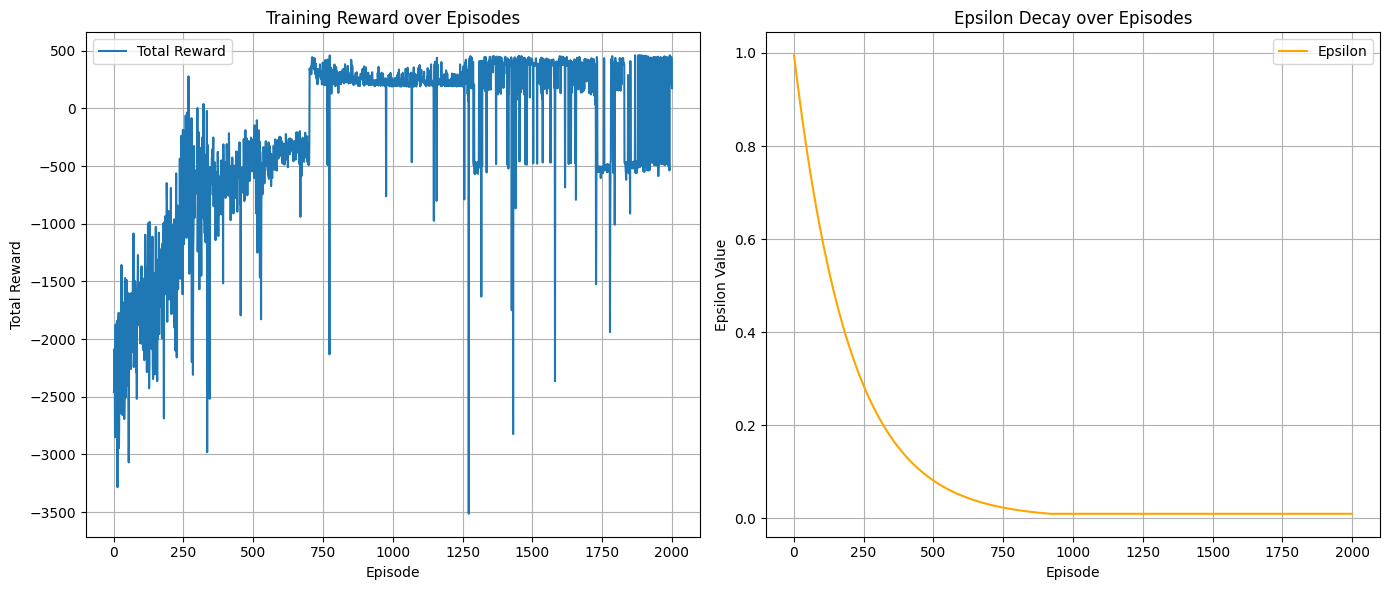

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
save_dir = "/content/temp"
rewards = np.load(os.path.join(save_dir, "rewards.npy"))
epsilons = np.load(os.path.join(save_dir, "epsilons.npy"))
episodes = np.arange(1, len(rewards) + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(episodes, rewards, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward over Episodes')
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(episodes, epsilons, color='orange', label='Epsilon')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay over Episodes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
def evaluate_greedy_policy(env, agents_q_net, num_episodes=5):
    rewards_per_eval = []
    for ep in range(num_episodes):
        obs_dict, _ = env.reset()
        obs = np.array([obs_dict[aid] for aid in env.agent_ids])
        state = env.get_centralized_state()
        total_reward = 0
        done = False
        step_count = 0

        while not done and step_count < MAX_STEPS:
            actions = []
            for i in range(NUM_AGENTS):
                with torch.no_grad():
                    q_values = agents_q_net[i](torch.tensor(obs[i], dtype=torch.float32, device=device))
                    a = q_values.argmax().item()
                actions.append(a)
            action_dict = {env.agent_ids[i]: actions[i] for i in range(NUM_AGENTS)}

            next_obs_dict, rewards_dict, dones_dict, truncs_dict, info = env.step(action_dict)
            next_obs = np.array([next_obs_dict[aid] for aid in env.agent_ids])
            obs = next_obs
            total_reward += sum(rewards_dict.values())
            done = all(dones_dict.values())
            step_count += 1
        print(f"Evaluation Episode {ep+1}: Total Reward = {total_reward:.2f}")
        rewards_per_eval.append(total_reward)
    return rewards_per_eval

Evaluation Episode  1 : Total Reward = 425.0
Evaluation Episode  2 : Total Reward = 427.5
Evaluation Episode  3 : Total Reward = 423.8
Evaluation Episode  4 : Total Reward = 426.2
Evaluation Episode  5 : Total Reward = 424.5


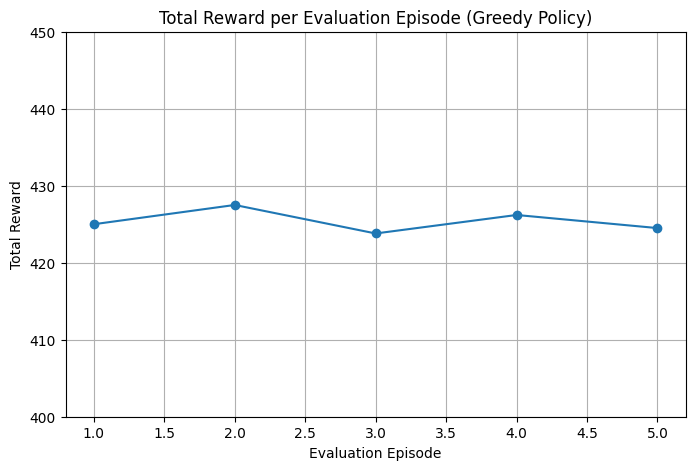

In [16]:
eval_rewards = evaluate_greedy_policy(env, agents_q_net, num_episodes=5)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eval_rewards)+1), eval_rewards, marker='o')
plt.xlabel('Evaluation Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Evaluation Episode (Greedy Policy)')
plt.grid(True)
plt.show()

In [8]:
def render_greedy_episode(env, agents_q_net):
    obs_dict, _ = env.reset()
    obs = np.array([obs_dict[aid] for aid in env.agent_ids])
    state = env.get_centralized_state()
    done = False
    step_count = 0
    while not done and step_count < MAX_STEPS:
        env.render()
        actions = []
        for i in range(NUM_AGENTS):
            with torch.no_grad():
                q_values = agents_q_net[i](torch.tensor(obs[i], dtype=torch.float32, device=device))
                a = q_values.argmax().item()
            actions.append(a)
        action_dict = {env.agent_ids[i]: actions[i] for i in range(NUM_AGENTS)}

        next_obs_dict, rewards_dict, dones_dict, truncs_dict, info = env.step(action_dict)
        next_obs = np.array([next_obs_dict[aid] for aid in env.agent_ids])
        obs = next_obs
        done = all(dones_dict.values())
        step_count += 1
    print("Rendered 1 greedy episode completed.")

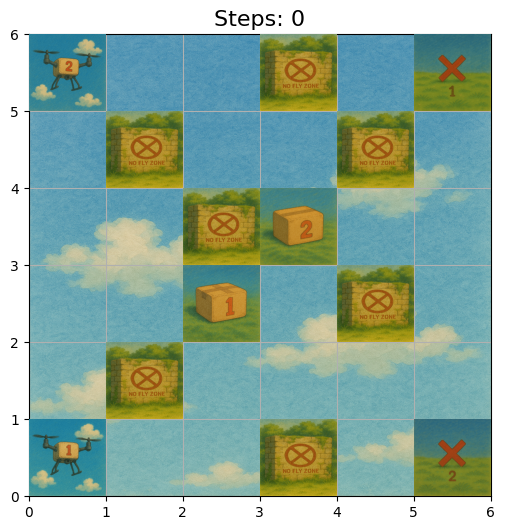

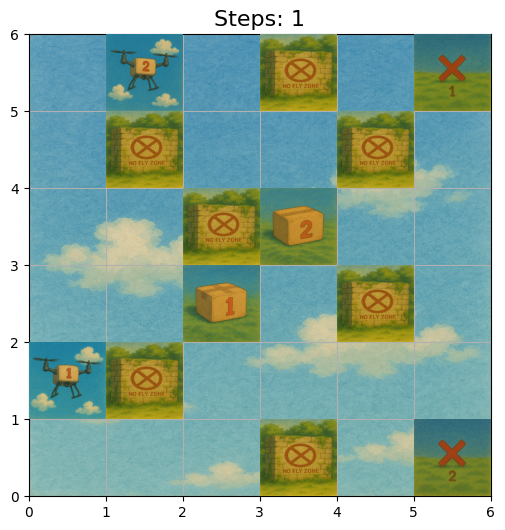

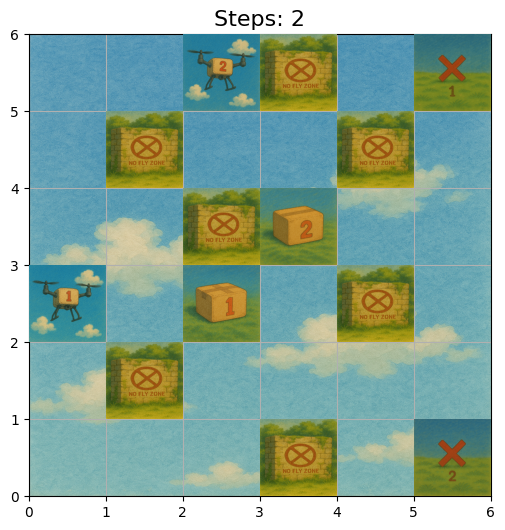

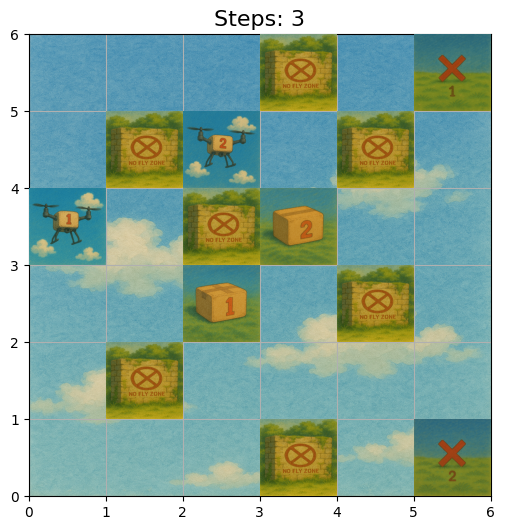

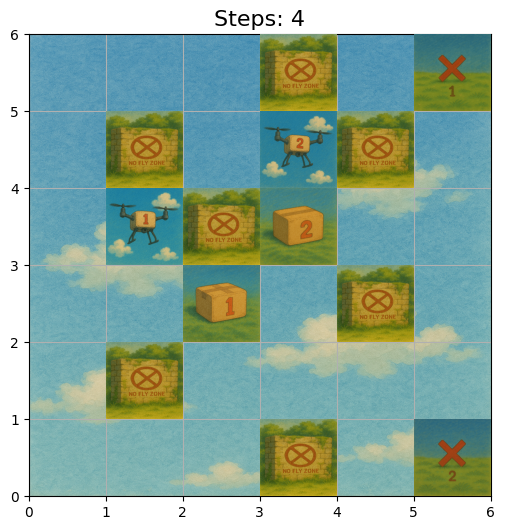

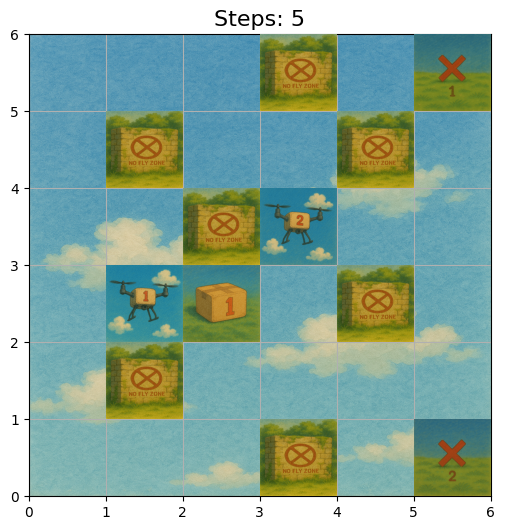

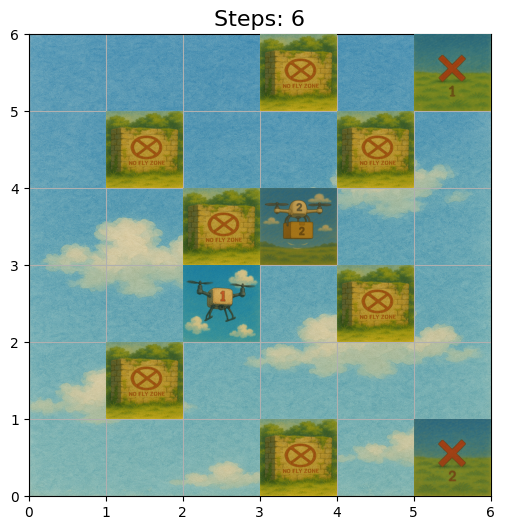

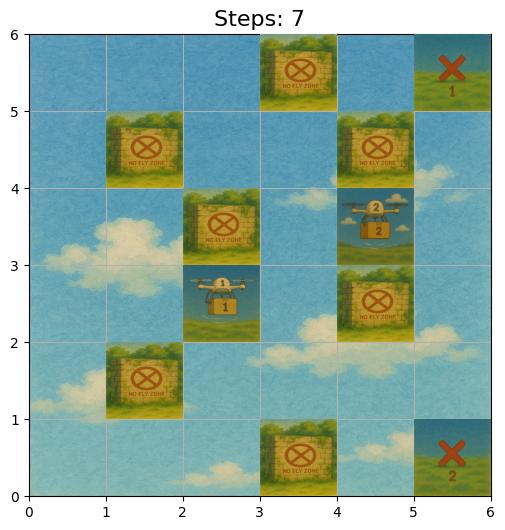

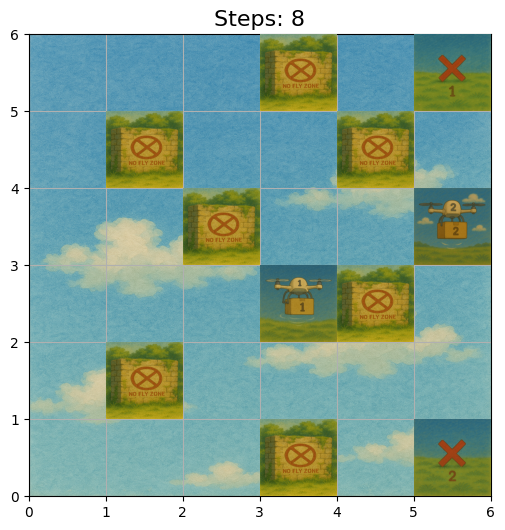

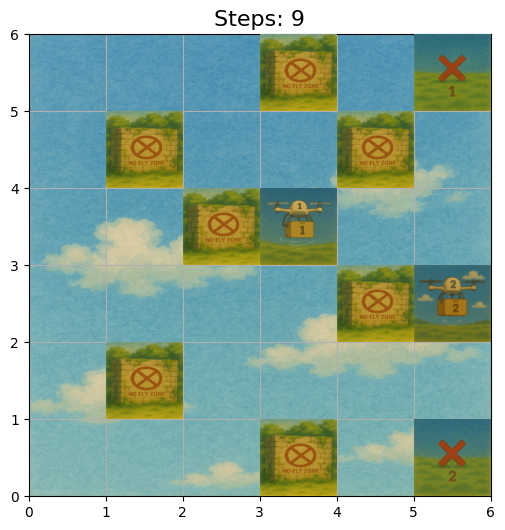

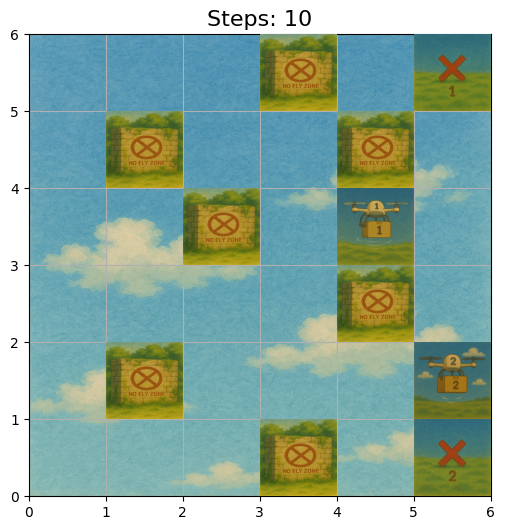

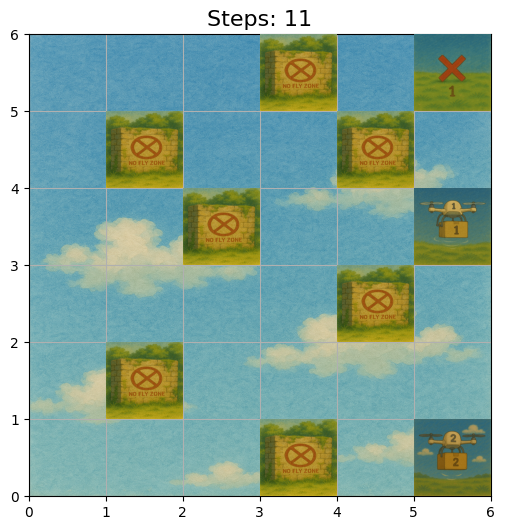

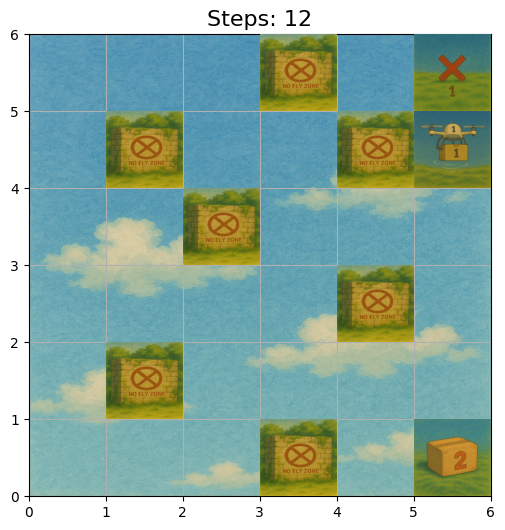

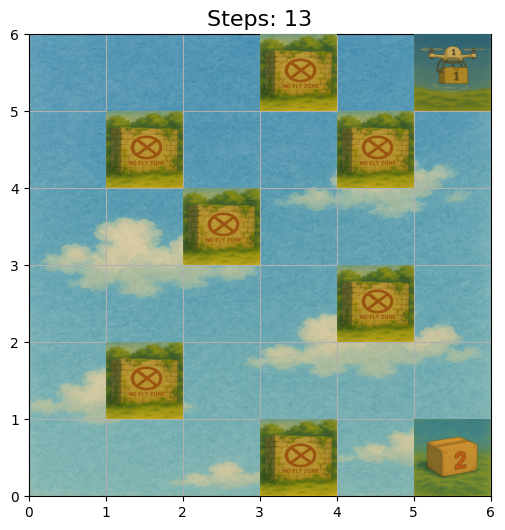

Rendered 1 greedy episode completed.


In [17]:
render_greedy_episode(env, agents_q_net)